# Importing dependencies

In [56]:
!pip install ipython-autotime
%load_ext autotime
%matplotlib inline

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 7.47 s


In [57]:
import numpy as np
import pandas as pd
import os,re,random
import unicodedata
import json

import matplotlib.pyplot as plt

import nltk
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords
from nltk.stem import wordnet 
from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk import pos_tag 
from sklearn.metrics import pairwise_distances 
from nltk import word_tokenize 

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential,Model

from tqdm.notebook import tqdm
from numba import jit, cuda

time: 3.47 ms


# Reading data

In [58]:
data_path = '/kaggle/input/cloud-counselage-qa-data/'
data_json = 'intents2.json'

with open(data_path+data_json) as json_data:
    intents_dict = json.load(json_data)

time: 6.97 ms


# Helper Functions

In [59]:
mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"couldnt" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"doesnt" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"havent" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"shouldnt" : "should not",
"that's" : "that is",
"thats" : "that is",
"there's" : "there is",
"theres" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"theyre":  "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


def replace_typical_misspell(text):
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

time: 7 ms


In [60]:

# Stopword list
pattern_stopwords = re.compile(r'\b('+r'|'.join(stopwords.words('english'))+r')\b\s*')

# @cuda.jit(device=True)
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# @tf.function()
def clean_text(text):
    text = unicode_to_ascii(text.lower().strip())
    
    #replacing email addresses with blank space
    text = re.sub(r"[a-zA-Z0-9_\-\.]+@[a-zA-Z0-9_\-\.]+\.[a-zA-Z]{2,5}","",text)
    
    #replacing urls with blank space
    text = re.sub(r"\bhttp:\/\/([^\/]*)\/([^\s]*)|https:\/\/([^\/]*)\/([^\s]*)","",text)
    
    # creating a space between a word and the punctuation following it
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    
    text = replace_typical_misspell(text)
    # replacing all the stopwords
    text = pattern_stopwords.sub('',text)
    
    # removes all the punctuations
    text = re.sub(r"[^a-z]+", " ", text)
    
    text = text.strip()

    # adding a start and an end token to the sentence so that the model know when to start and stop predicting.
#     text = '<start> ' + text + ' <end>'
    
    return text

clean_text_vect = np.vectorize(clean_text)

time: 4.75 ms


In [61]:
def chunk_clean(array,chunk_size=256):
    cleaned_array = []
    
    for i in tqdm(range(0, len(array), chunk_size)):
        text_chunk = clean_text_vect(array[i:i+chunk_size])
        cleaned_array.extend(text_chunk)

    return np.array(cleaned_array)

time: 1.54 ms


In [62]:
lema=wordnet.WordNetLemmatizer()
# stemmer = LancasterStemmer()

def text_normalization(text): 
    tokens=nltk.word_tokenize(text)     
    tags_list=pos_tag(tokens,tagset=None) 

    lema_words=[] 
    for token,pos_token in tags_list:
        if pos_token.startswith('V'):  # Verb
            pos_val='v'
        elif pos_token.startswith('J'): # Adjective
            pos_val='a'
        elif pos_token.startswith('R'): # Adverb
            pos_val='r'
        else:
            pos_val='n' # Noun
            
        lema_token=lema.lemmatize(token,pos_val)
#         stem_token=stemmer.stem(lema_token)
        lema_words.append(lema_token) 
    
    return " ".join(lema_words)

text_norm_vect = np.vectorize(text_normalization)

time: 2.97 ms


In [63]:
def chunk_text_normalize(array,chunk_size=256):
    norm_array = []
    
    for i in tqdm(range(0, len(array), chunk_size)):
        text_chunk = text_norm_vect(array[i:i+chunk_size])
        norm_array.extend(text_chunk)

    return np.array(norm_array)

time: 1.7 ms


# Data Preparation

In [65]:
qa_data = []    
for intent in intents_dict['intents']:
    for pattern in intent['patterns']:
        for response in intent['responses']:
            qa_data.append((pattern,response,intent['tag']))
            
data = pd.DataFrame(qa_data,columns=['question','response','tag'])
data['tag'] = pd.Categorical(data['tag'])
data['labels'] = data.tag.cat.codes
data.head()

,question,response,tag,labels
0,Hi there,Good to see you again,greeting,18
1,Hi there,"Hi there, how can I help?",greeting,18
2,Hi there,How can I help you?,greeting,18
3,Is anyone there?,Good to see you again,greeting,18
4,Is anyone there?,"Hi there, how can I help?",greeting,18


time: 18.4 ms


In [66]:
words = []
tags = []
documents = []
responses = []
ignore_words = ['?']

for intent in intents_dict['intents']:
    for pattern in intent['patterns']:
        pattern = text_normalization(clean_text(pattern))
        word = pattern.split()
        words.extend(word)
        documents.append((word, intent['tag']))
        
    tags.append(intent['tag'])
        
# words = [stemmer.stem(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

tags = sorted(list(tags))

print (len(documents), "documents")
print (len(tags), "tags")
print (len(words), "unique lemmetized words")

419 documents
66 tags
420 unique lemmetized words
time: 307 ms


In [67]:
training = []
output = []

output_empty = [0] * len(tags)

for doc in documents:
    bag = []
    pattern_words = doc[0]
    
    for word in words:
        bag.append(1) if word in pattern_words else bag.append(0)
        
    output_row = list(output_empty)
    output_row[tags.index(doc[1])] = 1

    training.append([bag, output_row])

np.random.shuffle(training)
training = np.array(training)

# create train and labels lists
train_x = list(training[:,0])
train_y = list(training[:,1])

time: 89.5 ms


# Modelling

In [68]:
def build_model(max_length = 1024, num_classes = 100):
    
    input_word_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")
            
    out = Dense(64,activation=tf.nn.swish)(input_word_ids)
    out = Dense(32,activation=tf.nn.swish)(out)
    out = Dense(num_classes, activation='softmax')(out)
    
    model = Model(inputs=input_word_ids, outputs=out)
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

time: 3.7 ms


In [69]:
model = build_model(max_length=len(train_x[0]),num_classes=len(tags))
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 420)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                26944     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 66)                2178      
Total params: 31,202
Trainable params: 31,202
Non-trainable params: 0
_________________________________________________________________
time: 76.4 ms


# Training the model

In [70]:
EPOCHS = 75
history = model.fit(np.array(train_x),np.array(train_y),epochs=EPOCHS)

Train on 419 samples
Epoch 1/75
419/419 [==============================] - 0s 914us/sample - loss: 4.1834 - accuracy: 0.0835
Epoch 2/75
419/419 [==============================] - 0s 75us/sample - loss: 4.1459 - accuracy: 0.2172
Epoch 3/75
419/419 [==============================] - 0s 70us/sample - loss: 4.1084 - accuracy: 0.2697
Epoch 4/75
419/419 [==============================] - 0s 70us/sample - loss: 4.0627 - accuracy: 0.2697
Epoch 5/75
419/419 [==============================] - 0s 87us/sample - loss: 4.0023 - accuracy: 0.2983
Epoch 6/75
419/419 [==============================] - 0s 94us/sample - loss: 3.9177 - accuracy: 0.2888
Epoch 7/75
419/419 [==============================] - 0s 83us/sample - loss: 3.7939 - accuracy: 0.2291
Epoch 8/75
419/419 [==============================] - 0s 73us/sample - loss: 3.6230 - accuracy: 0.2458
Epoch 9/75
419/419 [==============================] - 0s 67us/sample - loss: 3.4077 - accuracy: 0.3055
Epoch 10/75
419/419 [==============================

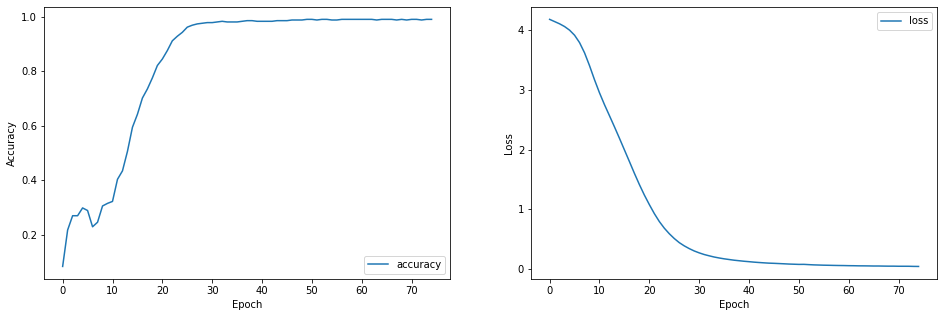

time: 353 ms


In [71]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.plot(epochs_range,history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(122)
plt.plot(epochs_range,history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Predictions

In [72]:
def bow(sentence, vector, show_details=False):
    
    sentence_words = text_normalization(clean_text(sentence))
    
    bag = [0]*len(vector)  
    for s in sentence_words.split():
        for i,w in enumerate(vector):
            if w == s: 
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)

    return(np.array(bag))

time: 2.46 ms


In [73]:
ERROR_THRESHOLD = 0.25
def classify(sentence):
    sent = pd.DataFrame([bow(sentence,vector=words)],dtype=float,index=['input'])

    results = model.predict([sent])[0]
    results = [[i,r] for i,r in enumerate(results) if r>ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    
    return_list = []
    for r in results:
        return_list.append((tags[r[0]], r[1]))
    
    return return_list

time: 2.97 ms


In [74]:
classify('part of which workgroups')

[('not_in_a_workgroup', 0.78577244)]

time: 119 ms


In [75]:
def predict_response(sentence, show_details=False):
    results = classify(sentence)
    if show_details:
            print('Tag: ',results[0][0])
    if results:
        while results:
            for i in intents_dict['intents']:
                if i['tag'] == results[0][0]:
                    response = random.choice(i['responses'])
                    return response

time: 1.93 ms


In [76]:
text="working hours"
predict_response(text)

'Our interns need to only make sure that they are online for 1 hour per day or 7 hours a week.'

time: 90 ms


# Interacting with chatbot

In [77]:
def chat():
    print('NATUKAKA: Welcome User, I am a chatbot assistant\n')
    while True:
        text = str(input('YOU: '))
        
        if text=='quit':
            print('NATUKAKA: ','Bye, See you again soon!','\n')
            break
            
        response = predict_response(text)
        print('NATUKAKA: ',response,'\n')

time: 1.53 ms


In [78]:
chat()

NATUKAKA: Welcome User, I am a chatbot assistant

YOU: hello
NATUKAKA:  Hi there, how can I help? 

YOU: i not part of any workgroups
NATUKAKA:  Every intern should be a part of 2 workgroups.
'202003-IP' -- This is a general workgroup. Everyone who is enrolled in IP should be a part of this workgroup.
'202003-IP-Technology'  -- This is a technology-specific workgroup. You'll be added to the technology you had enrolled for. For example “202003-IP-Python” for students who enrolled for python. If anyone has not been added to any of these workgroups, kindly message “Cloud Counselage HR” regarding the same over bitrix24 platform. 

YOU: I am not able to access my Bitrix24 account?
NATUKAKA:  If you have submitted the ‘New Joinee Form’ after the 1st of March, please wait till the 31st of March to receive your access.

If you have recieved the invitation and have forgotten the password then,
Go to https://cloudcounselage24.bitrix24.com/ On the Login page, In the, ‘Enter the phone number or em

# THE END